In [102]:
import numpy as np
import pandas as pd
import sklearn
import geopandas as gpd 
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import plot_roc_curve,precision_recall_curve, plot_precision_recall_curve
from xgboost import XGBClassifier
import shap

/Users/winsometang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [2]:
beat_file = pd.read_csv('PoliceBeatDec2012.csv')
beat_file=beat_file.drop(columns = ['the_geom','SECTOR','BEAT'])

In [3]:
clean_crash = pd.read_csv('crash_clean.csv')

/Users/winsometang/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
clean_vehicles = pd.read_csv('clean_vehicles.csv')

In [5]:
clean_people = pd.read_csv('clean_people.csv')

/Users/winsometang/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (4,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
clean_crash.describe()

,Unnamed: 0,POSTED_SPEED_LIMIT,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LANE_CNT
count,517282.00000,517282.000000,517282.000000,517282.000000,517282.000000,514382.000000,514382.000000,1.989660e+05
mean,258640.50000,28.302120,13.242158,4.126892,6.573674,41.855046,-87.673046,1.333242e+01
std,149326.59531,6.444674,5.506523,1.977442,3.438811,0.336088,0.683169,2.961921e+03
min,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,-87.934763,0.000000e+00
25%,129320.25000,30.000000,9.000000,2.000000,4.000000,41.782219,-87.721285,2.000000e+00
50%,258640.50000,30.000000,14.000000,4.000000,7.000000,41.875409,-87.673455,2.000000e+00
75%,387960.75000,30.000000,17.000000,6.000000,10.000000,41.924046,-87.632828,4.000000e+00
max,517281.00000,99.000000,23.000000,7.000000,12.000000,42.022780,0.000000,1.191625e+06


In [7]:
clean_people.describe()

,Unnamed: 0,AGE,BAC_RESULT VALUE
count,1.142379e+06,815720.000000,1.142379e+06
mean,5.715878e+05,37.847115,2.140358e-04
std,3.299286e+05,17.106371,6.961254e-03
min,0.000000e+00,-177.000000,0.000000e+00
25%,2.858925e+05,25.000000,0.000000e+00
50%,5.716430e+05,35.000000,0.000000e+00
75%,8.573105e+05,50.000000,0.000000e+00
max,1.142962e+06,110.000000,1.000000e+00


In [8]:
clean_vehicles.describe()

,Unnamed: 0,CRASH_UNIT_ID
count,1.057474e+06,1.057474e+06
mean,5.287365e+05,5.642652e+05
std,3.052666e+05,3.276157e+05
min,0.000000e+00,2.000000e+00
25%,2.643682e+05,2.790312e+05
50%,5.287365e+05,5.645995e+05
75%,7.931048e+05,8.490518e+05
max,1.057473e+06,1.129364e+06


In [9]:
clean_vehicles.head(10)

,Unnamed: 0,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,MAKE,MODEL,VEHICLE_TYPE,VEHICLE_DEFECT,TRAVEL_DIRECTION,MANEUVER,FIRST_CONTACT_POINT,FIRE_I
0,0,829999,24ddf9fd8542199d832e1c223cc474e5601b356f1d77a6...,01/22/2020 06:25:00 AM,INFINITI,UNKNOWN,PASSENGER,NONE,N,STRAIGHT AHEAD,FRONT,N
1,1,749947,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,09/28/2019 03:30:00 AM,HONDA,CIVIC,PASSENGER,UNKNOWN,N,STRAIGHT AHEAD,FRONT,N
2,2,749949,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,09/28/2019 03:30:00 AM,TOYOTA,YARIS,UNKNOWN/NA,NONE,N,PARKED,ROOF,N
3,3,749950,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,09/28/2019 03:30:00 AM,GENERAL MOTORS CORPORATION (GMC),SIERRA,UNKNOWN/NA,UNKNOWN,N,PARKED,ROOF,N
4,4,871921,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,04/13/2020 10:50:00 PM,BUICK,ENCORE,PASSENGER,NONE,W,STRAIGHT AHEAD,FRONT-RIGHT,N
5,5,473653,80f5b6eff349a72094c9c7a11745549caa8bd39b57cedd...,09/09/2018 08:50:00 AM,LINCOLN-CONTINENTAL,MKT,PASSENGER,NONE,S,PARKED,FRONT-LEFT,N
6,6,834812,ecf9e646f89a73ed3df0f373e4fbd18e91f5a595004019...,02/03/2020 03:45:00 PM,HONDA,CRV,PASSENGER,NONE,W,STRAIGHT AHEAD,OTHER,N
7,7,834813,ecf9e646f89a73ed3df0f373e4fbd18e91f5a595004019...,02/03/2020 03:45:00 PM,SUBARU,FORESTER,PASSENGER,NONE,S,STRAIGHT AHEAD,ROOF,N
8,8,837380,c7c57a49274b3aa953d0b76346f68e116ed8c3d72a683a...,02/06/2020 12:00:00 AM,UNKNOWN,UNKNOWN,UNKNOWN/NA,UNKNOWN,UNKNOWN,UNKNOWN/NA,UNKNOWN,N
9,9,837381,c7c57a49274b3aa953d0b76346f68e116ed8c3d72a683a...,02/06/2020 12:00:00 AM,INFINITI,UNKNOWN,PASSENGER,UNKNOWN,UNKNOWN,PARKED,TOTAL (ALL AREAS),N


In [10]:
clean_crash.head(10)

,Unnamed: 0,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,...,INJURIES_TOTAL,INJURIES_FATAL,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,TRAFFICWAY_TYPE,LANE_CNT
0,0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,07/10/2019 05:56:00 PM,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,17,4,7,41.919664,-87.773288,POINT (-87.773287883007 41.919663832993),ONE-WAY,NaN
1,1,009e9e67203442370272e1a13d6ee51a4155dac65e583d...,06/30/2017 04:00:00 PM,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,16,6,6,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989),NOT DIVIDED,4.0
2,2,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,07/10/2020 10:25:00 AM,30,CLEAR,DAYLIGHT,REAR END,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,10,6,7,41.773456,-87.585022,POINT (-87.585022352022 41.773455972008),FOUR WAY,NaN
3,3,f8960f698e870ebdc60b521b2a141a5395556bc3704191...,07/11/2020 01:00:00 AM,30,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,1,7,7,41.802119,-87.622115,POINT (-87.622114914961 41.802118543011),DIVIDED - W/MEDIAN (NOT RAISED),NaN
4,4,8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...,07/08/2020 02:00:00 PM,20,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,14,4,7,NaN,NaN,NaN,DRIVEWAY,NaN
5,5,00e47f189660cd8ba1e85fc63061bf1d8465184393f134...,03/21/2019 10:50:00 PM,30,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,22,5,3,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989),NOT DIVIDED,4.0
6,6,0126747fc9ffc0edc9a38abb83d80034f897db0f739eef...,03/26/2018 02:23:00 PM,35,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,14,2,3,41.953647,-87.732082,POINT (-87.732081736006 41.953646899951),NOT DIVIDED,NaN
7,7,f636d4a51a88015ac89031159b1f1952b8d92e49d11aeb...,07/10/2020 10:20:00 PM,30,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE OPPOSITE DIRECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,1.0,0.0,22,6,7,41.880386,-87.725807,POINT (-87.725807044026 41.880385884998),NOT DIVIDED,NaN
8,8,76aabcf7c2219a5c90259c96fe94b33834ddb53e0dbcd3...,07/09/2020 05:06:00 PM,10,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,...,0.0,0.0,17,5,7,NaN,NaN,NaN,PARKING LOT,NaN
9,9,9c974548026c1b962569040bd8fa08ae643ffc28c15ebd...,06/29/2020 05:55:00 PM,10,CLOUDY/OVERCAST,DAWN,PARKED MOTOR VEHICLE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,17,2,6,NaN,NaN,NaN,PARKING LOT,NaN


In [11]:
clean_vehicles.head(10)

,Unnamed: 0,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,MAKE,MODEL,VEHICLE_TYPE,VEHICLE_DEFECT,TRAVEL_DIRECTION,MANEUVER,FIRST_CONTACT_POINT,FIRE_I
0,0,829999,24ddf9fd8542199d832e1c223cc474e5601b356f1d77a6...,01/22/2020 06:25:00 AM,INFINITI,UNKNOWN,PASSENGER,NONE,N,STRAIGHT AHEAD,FRONT,N
1,1,749947,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,09/28/2019 03:30:00 AM,HONDA,CIVIC,PASSENGER,UNKNOWN,N,STRAIGHT AHEAD,FRONT,N
2,2,749949,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,09/28/2019 03:30:00 AM,TOYOTA,YARIS,UNKNOWN/NA,NONE,N,PARKED,ROOF,N
3,3,749950,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,09/28/2019 03:30:00 AM,GENERAL MOTORS CORPORATION (GMC),SIERRA,UNKNOWN/NA,UNKNOWN,N,PARKED,ROOF,N
4,4,871921,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,04/13/2020 10:50:00 PM,BUICK,ENCORE,PASSENGER,NONE,W,STRAIGHT AHEAD,FRONT-RIGHT,N
5,5,473653,80f5b6eff349a72094c9c7a11745549caa8bd39b57cedd...,09/09/2018 08:50:00 AM,LINCOLN-CONTINENTAL,MKT,PASSENGER,NONE,S,PARKED,FRONT-LEFT,N
6,6,834812,ecf9e646f89a73ed3df0f373e4fbd18e91f5a595004019...,02/03/2020 03:45:00 PM,HONDA,CRV,PASSENGER,NONE,W,STRAIGHT AHEAD,OTHER,N
7,7,834813,ecf9e646f89a73ed3df0f373e4fbd18e91f5a595004019...,02/03/2020 03:45:00 PM,SUBARU,FORESTER,PASSENGER,NONE,S,STRAIGHT AHEAD,ROOF,N
8,8,837380,c7c57a49274b3aa953d0b76346f68e116ed8c3d72a683a...,02/06/2020 12:00:00 AM,UNKNOWN,UNKNOWN,UNKNOWN/NA,UNKNOWN,UNKNOWN,UNKNOWN/NA,UNKNOWN,N
9,9,837381,c7c57a49274b3aa953d0b76346f68e116ed8c3d72a683a...,02/06/2020 12:00:00 AM,INFINITI,UNKNOWN,PASSENGER,UNKNOWN,UNKNOWN,PARKED,TOTAL (ALL AREAS),N


In [12]:
clean_people.shape

(1142379, 16)

In [13]:
clean_vehicles.shape

(1057474, 12)

In [14]:
clean_crash.shape

(517282, 27)

In [15]:
clean_crash.drop_duplicates(inplace=True)
clean_vehicles.drop_duplicates(inplace= True)
clean_people.drop_duplicates(inplace = True)

In [16]:
mergeddf=clean_crash.drop_duplicates().merge(clean_vehicles.drop_duplicates(),on='CRASH_RECORD_ID').merge(clean_people.drop_duplicates(),on='CRASH_RECORD_ID')

In [17]:
# df =clean_people.merge(clean_vehicles.drop_duplicates(),how ='inner',left_on='CRASH_RECORD_ID', right_on= 'CRASH_RECORD_ID')

In [18]:
mergeddf.describe()

,Unnamed: 0_x,POSTED_SPEED_LIMIT,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LANE_CNT,Unnamed: 0_y,CRASH_UNIT_ID,Unnamed: 0,AGE,BAC_RESULT VALUE
count,2.412776e+06,2.412776e+06,2.412776e+06,2.412776e+06,2.412776e+06,2.399324e+06,2.399324e+06,9.296760e+05,2.412776e+06,2.412776e+06,2.412776e+06,1.727995e+06,2.412776e+06
mean,2.542429e+05,2.886386e+01,1.350763e+01,4.148680e+00,6.590377e+00,4.185222e+01,-8.766854e+01,9.349354e+00,5.250276e+05,5.676385e+05,5.702466e+05,3.773590e+01,2.414066e-04
std,1.514699e+05,5.905738e+00,5.394394e+00,1.988100e+00,3.423331e+00,4.496020e-01,9.267125e-01,2.110810e+03,3.068851e+05,3.259501e+05,3.327499e+05,1.710756e+01,7.356951e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-8.793476e+01,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,-1.770000e+02,0.000000e+00
25%,1.219690e+05,3.000000e+01,1.000000e+01,2.000000e+00,4.000000e+00,4.178215e+01,-8.772162e+01,2.000000e+00,2.577478e+05,2.850108e+05,2.797910e+05,2.500000e+01,0.000000e+00
50%,2.540475e+05,3.000000e+01,1.400000e+01,4.000000e+00,7.000000e+00,4.187489e+01,-8.767357e+01,2.000000e+00,5.244035e+05,5.697720e+05,5.696345e+05,3.500000e+01,0.000000e+00
75%,3.854432e+05,3.000000e+01,1.700000e+01,6.000000e+00,1.000000e+01,4.192198e+01,-8.763256e+01,4.000000e+00,7.905772e+05,8.496552e+05,8.599260e+05,5.000000e+01,0.000000e+00
max,5.172810e+05,9.900000e+01,2.300000e+01,7.000000e+00,1.200000e+01,4.202278e+01,0.000000e+00,1.191625e+06,1.057473e+06,1.129364e+06,1.142962e+06,1.100000e+02,1.000000e+00


In [19]:

mergeddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2412776 entries, 0 to 2412775
Data columns (total 53 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0_x             int64  
 1   CRASH_RECORD_ID          object 
 2   CRASH_DATE_x             object 
 3   POSTED_SPEED_LIMIT       int64  
 4   WEATHER_CONDITION        object 
 5   LIGHTING_CONDITION       object 
 6   FIRST_CRASH_TYPE         object 
 7   ALIGNMENT                object 
 8   ROADWAY_SURFACE_COND     object 
 9   ROAD_DEFECT              object 
 10  CRASH_TYPE               object 
 11  PRIM_CONTRIBUTORY_CAUSE  object 
 12  SEC_CONTRIBUTORY_CAUSE   object 
 13  STREET_DIRECTION         object 
 14  BEAT_OF_OCCURRENCE       object 
 15  WORK_ZONE_I              object 
 16  MOST_SEVERE_INJURY       object 
 17  INJURIES_TOTAL           object 
 18  INJURIES_FATAL           object 
 19  CRASH_HOUR               int64  
 20  CRASH_DAY_OF_WEEK        int64  
 21  CRASH_MO

In [20]:
mergeddf.drop_duplicates(inplace = True)
mergeddf.shape

(2412776, 53)

In [21]:
mergeddf['MOST_SEVERE_INJURY'].value_counts()


NO INDICATION OF INJURY     1975459
NONINCAPACITATING INJURY     239348
REPORTED, NOT EVIDENT        136521
INCAPACITATING INJURY         57052
FATAL                          4396
Name: MOST_SEVERE_INJURY, dtype: int64

In [22]:
mergeddf['INJURIES_FATAL'].value_counts()

0.0    2408380
1.0       3991
2.0        297
3.0         68
4.0         40
Name: INJURIES_FATAL, dtype: int64

In [23]:
mergeddf["FATAL"]= pd.to_numeric(mergeddf["INJURIES_FATAL"])


In [24]:
mergeddf['FATAL'].value_counts()



0.0    2408380
1.0       3991
2.0        297
3.0         68
4.0         40
Name: FATAL, dtype: int64

In [25]:
mergeddf.isnull().sum()


Unnamed: 0_x                     0
CRASH_RECORD_ID                  0
CRASH_DATE_x                     0
POSTED_SPEED_LIMIT               0
WEATHER_CONDITION                0
LIGHTING_CONDITION               0
FIRST_CRASH_TYPE                 0
ALIGNMENT                        0
ROADWAY_SURFACE_COND             0
ROAD_DEFECT                      0
CRASH_TYPE                       0
PRIM_CONTRIBUTORY_CAUSE          0
SEC_CONTRIBUTORY_CAUSE           0
STREET_DIRECTION                10
BEAT_OF_OCCURRENCE               0
WORK_ZONE_I                      0
MOST_SEVERE_INJURY               0
INJURIES_TOTAL                   0
INJURIES_FATAL                   0
CRASH_HOUR                       0
CRASH_DAY_OF_WEEK                0
CRASH_MONTH                      0
LATITUDE                     13452
LONGITUDE                    13452
LOCATION                     13452
TRAFFICWAY_TYPE                  0
LANE_CNT                   1483100
Unnamed: 0_y                     0
CRASH_UNIT_ID       

In [26]:
mergeddf.FATAL[mergeddf.FATAL > 0] = 1
mergeddf.FATAL[mergeddf.FATAL == 0] = 0

/var/folders/nt/rg8_jkq90v77r8l8dc_9wl0m0000gn/T/ipykernel_25140/2906185067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mergeddf.FATAL[mergeddf.FATAL > 0] = 1
/var/folders/nt/rg8_jkq90v77r8l8dc_9wl0m0000gn/T/ipykernel_25140/2906185067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mergeddf.FATAL[mergeddf.FATAL == 0] = 0


In [27]:
mergeddf.FATAL.value_counts()



0.0    2408380
1.0       4396
Name: FATAL, dtype: int64

In [28]:
model_data =mergeddf.drop(columns=['Unnamed: 0_x','Unnamed: 0','CRASH_DATE_x','CRASH_DATE_y','CRASH_DATE_y','Unnamed: 0_y','PERSON_ID','CRASH_RECORD_ID', 'VEHICLE_ID','CRASH_DATE','INJURIES_FATAL','LATITUDE', 'LONGITUDE', 'LOCATION','MOST_SEVERE_INJURY','INJURY_CLASSIFICATION'])


In [ ]:
model_data['FIRST_CRASH_TYPE'].value_counts()

In [29]:
ten_samp = model_data[['EJECTION','AIRBAG_DEPLOYED',
       'SAFETY_EQUIPMENT',
       'MODEL','FIRST_CONTACT_POINT','INJURIES_TOTAL','SEX','AGE','CRASH_HOUR','CRASH_MONTH']]


In [30]:
model_data.columns

Index(['POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'CRASH_TYPE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE',
       'STREET_DIRECTION', 'BEAT_OF_OCCURRENCE', 'WORK_ZONE_I',
       'INJURIES_TOTAL', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'CRASH_UNIT_ID', 'MAKE', 'MODEL',
       'VEHICLE_TYPE', 'VEHICLE_DEFECT', 'TRAVEL_DIRECTION', 'MANEUVER',
       'FIRST_CONTACT_POINT', 'FIRE_I', 'PERSON_TYPE', 'SEX', 'AGE',
       'EJECTION', 'AIRBAG_DEPLOYED', 'DRIVER_ACTION', 'PEDPEDAL_ACTION',
       'PHYSICAL_CONDITION', 'BAC_RESULT VALUE', 'SAFETY_EQUIPMENT', 'FATAL'],
      dtype='object')

In [31]:
model_data['INJURIES_TOTAL'] = pd.to_numeric(model_data['INJURIES_TOTAL'])
model_data.INJURIES_TOTAL[model_data.INJURIES_TOTAL > 0] = 1
model_data.INJURIES_TOTAL[model_data.INJURIES_TOTAL == 0] = 0


/var/folders/nt/rg8_jkq90v77r8l8dc_9wl0m0000gn/T/ipykernel_25140/2086929565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.INJURIES_TOTAL[model_data.INJURIES_TOTAL > 0] = 1
/var/folders/nt/rg8_jkq90v77r8l8dc_9wl0m0000gn/T/ipykernel_25140/2086929565.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.INJURIES_TOTAL[model_data.INJURIES_TOTAL == 0] = 0


In [32]:
model_data.shape

(2412776, 39)

In [33]:
model_data['INJURIES_TOTAL'].value_counts()

0.0    1975459
1.0     437317
Name: INJURIES_TOTAL, dtype: int64

In [34]:
model_data["SEX"]

0          M
1          M
2          M
3          M
4          M
          ..
2412771    M
2412772    F
2412773    F
2412774    F
2412775    F
Name: SEX, Length: 2412776, dtype: object

In [35]:
injured_df = model_data[model_data['INJURIES_TOTAL']>0]
non_injured_df = model_data[model_data['INJURIES_TOTAL']==0]
fata_sub = model_data[model_data['FATAL']>0]

In [36]:
model_data['AGE']= model_data['AGE'].abs()

In [37]:
# pd.to_numeric(model_data.CRASH_MONTH)
# model_data.CRASH_MONTH[model_data["CRASH_MONTH"]<=3] = "Q1"
# model_data.CRASH_MONTH[model_data["CRASH_MONTH"]>=10] = "Q4"
# model_data.CRASH_MONTH[model_data["CRASH_MONTH"]==9] = "Q3"
# model_data.CRASH_MONTH[model_data["CRASH_MONTH"]==8] = "Q3"
# model_data.CRASH_MONTH[model_data["CRASH_MONTH"]==7] = "Q3"
# model_data.CRASH_MONTH[model_data["CRASH_MONTH"]==4] = "Q2"
# model_data.CRASH_MONTH[model_data["CRASH_MONTH"]==5] = "Q2"
# model_data.CRASH_MONTH[model_data["CRASH_MONTH"]==6] = "Q2"

In [38]:
model_data.CRASH_MONTH.value_counts()

6     225379
5     222036
10    218377
12    205543
9     202761
11    199098
8     196878
3     192852
1     190563
7     188483
2     186656
4     184150
Name: CRASH_MONTH, dtype: int64

In [39]:
model_data["BEAT_OF_OCCURRENCE"].value_counts()

1834.0     23990
114.0      20627
122.0      18483
1831.0     18322
813.0      18106
           ...  
1652.0       354
1655.0       308
UNKNOWN       24
1653.0         4
6100.0         2
Name: BEAT_OF_OCCURRENCE, Length: 548, dtype: int64

In [40]:
model_data['BEAT_NUM']= model_data["BEAT_OF_OCCURRENCE"]

In [41]:
model_data = model_data[model_data["BEAT_NUM"]!='UNKNOWN']
model_data['BEAT_NUM']=model_data['BEAT_NUM'].astype(float).astype(int)


In [42]:
model_data['BEAT_NUM']

0          2515
1          2515
2          2515
3          2515
4          2515
           ... 
2412771     132
2412772     132
2412773     132
2412774     132
2412775     132
Name: BEAT_NUM, Length: 2412752, dtype: int64

In [43]:
test=pd.merge(model_data,beat_file, how= 'inner', left_on=['BEAT_NUM'],right_on =['BEAT_NUM'])

In [44]:
test

,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,CRASH_TYPE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,...,EJECTION,AIRBAG_DEPLOYED,DRIVER_ACTION,PEDPEDAL_ACTION,PHYSICAL_CONDITION,BAC_RESULT VALUE,SAFETY_EQUIPMENT,FATAL,BEAT_NUM,DISTRICT
0,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,IMPROPER BACKING,UNABLE TO DETERMINE,...,NONE,NOT APPLICABLE,IMPROPER BACKING,UNKNOWN/NA,NORMAL,0.0,USAGE UNKNOWN,0.0,2515,25
1,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,IMPROPER BACKING,UNABLE TO DETERMINE,...,NONE,NOT APPLICABLE,NONE,UNKNOWN/NA,NORMAL,0.0,USAGE UNKNOWN,0.0,2515,25
2,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,IMPROPER BACKING,UNABLE TO DETERMINE,...,NONE,NOT APPLICABLE,NaN,UNKNOWN/NA,UNKNOWN,0.0,USAGE UNKNOWN,0.0,2515,25
3,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,IMPROPER BACKING,UNABLE TO DETERMINE,...,NONE,NOT APPLICABLE,IMPROPER BACKING,UNKNOWN/NA,NORMAL,0.0,USAGE UNKNOWN,0.0,2515,25
4,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,IMPROPER BACKING,UNABLE TO DETERMINE,...,NONE,NOT APPLICABLE,NONE,UNKNOWN/NA,NORMAL,0.0,USAGE UNKNOWN,0.0,2515,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412745,30,RAIN,DAYLIGHT,REAR END,STRAIGHT AND LEVEL,WET,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,...,NONE,DID NOT DEPLOY,NONE,UNKNOWN/NA,NORMAL,0.0,USAGE UNKNOWN,0.0,723,7
2412746,30,RAIN,DAYLIGHT,REAR END,STRAIGHT AND LEVEL,WET,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,...,NONE,"DEPLOYED, FRONT",NaN,UNKNOWN/NA,UNKNOWN,0.0,USAGE UNKNOWN,0.0,723,7
2412747,20,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,INJURY AND / OR TOW DUE TO CRASH,UNABLE TO DETERMINE,UNABLE TO DETERMINE,...,NONE,DEPLOYMENT UNKNOWN,UNKNOWN,UNKNOWN/NA,UNKNOWN,0.0,USAGE UNKNOWN,0.0,723,7
2412748,20,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,INJURY AND / OR TOW DUE TO CRASH,UNABLE TO DETERMINE,UNABLE TO DETERMINE,...,NONE,DEPLOYMENT UNKNOWN,UNKNOWN,UNKNOWN/NA,UNKNOWN,0.0,USAGE UNKNOWN,0.0,723,7


<AxesSubplot:title={'center':'District of Occurrence'}, xlabel='District Number'>

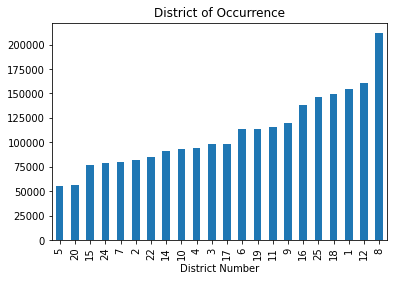

In [45]:
test["DISTRICT"].value_counts().sort_values().plot(kind = 'bar',title= 'District of Occurrence',xlabel= 'District Number')

<AxesSubplot:>

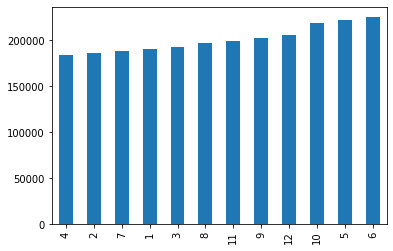

In [46]:
test["CRASH_MONTH"].value_counts().sort_values().plot(kind = 'bar')

<AxesSubplot:title={'center':'Time When Most Crash Occur in 24 Hrs'}, xlabel='Hour of Day', ylabel='Counts'>

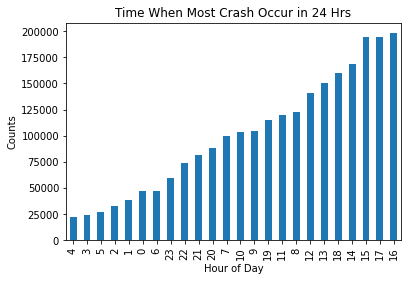

In [47]:
test['CRASH_HOUR'].value_counts().sort_values().plot(kind = 'bar',title = 'Time When Most Crash Occur in 24 Hrs',xlabel = "Hour of Day", ylabel = "Counts")

In [48]:
col = 'CRASH_HOUR'
conditions = [test[col].between(5,11),test[col].between(12,17),test[col].between(18,21),test[col].between(22,24),test[col].between(0,4)]
choices = ['Morning','Afternoon','Evening','Night','Night']
test["CRASH_TOD"]= np.select(conditions,choices,default = np.nan)
# test["CRASH_HOUR"] = np.where(test['CRASH_HOUR'].between(5,11),'Morning',test['CRASH_HOUR'])
# test["CRASH_HOUR"] = np.where(test['CRASH_HOUR'].between(12,17),'Afternoon',test['CRASH_HOUR'])
# test["CRASH_HOUR"] = np.where(test['CRASH_HOUR'].between(18,21),'Evening',test['CRASH_HOUR'])
# test["CRASH_HOUR"] = np.where(test['CRASH_HOUR'].between(22,24),'Night',test['CRASH_HOUR'])
# test["CRASH_HOUR"] = np.where(test['CRASH_HOUR'].between(1,4),'Night',test['CRASH_HOUR'])

In [49]:
test['CRASH_TOD'].value_counts()

Afternoon    1047401
Morning       624166
Evening       444778
Night         296405
Name: CRASH_TOD, dtype: int64

In [50]:
model_data['WEATHER_CONDITION'].value_counts()

CLEAR                       1929814
RAIN                         222811
SNOW                          88970
UNKNOWN                       76334
CLOUDY/OVERCAST               75660
OTHER                          7434
FOG/SMOKE/HAZE                 3995
SLEET/HAIL                     3428
FREEZING RAIN/DRIZZLE          3163
BLOWING SNOW                    730
SEVERE CROSS WIND GATE          405
BLOWING SAND, SOIL, DIRT          8
Name: WEATHER_CONDITION, dtype: int64

<AxesSubplot:title={'center':'Common Crash Month'}, xlabel='Month by Number', ylabel='Crash Count'>

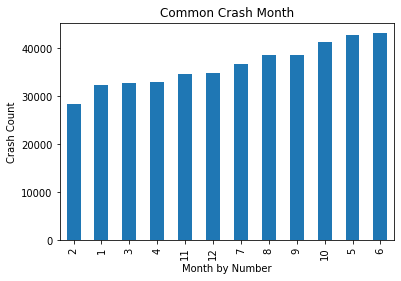

In [51]:
injured_df["CRASH_MONTH"].value_counts().sort_values().plot(kind = 'bar',title = 'Common Crash Month',xlabel= 'Month by Number', ylabel = 'Crash Count')

In [52]:
col = 'CRASH_MONTH'
conditions = [test[col].between(1,3),test[col].between(4,6),test[col].between(7,9),test[col].between(10,12)]
choices = ['Q1','Q2','Q3','Q4']
test["QUARTER"]= np.select(conditions,choices,default = np.nan)

In [53]:
# col = 'AGE'
# conditions = [test[col].between(0,10),test[col].between(11,20),test[col].between(21,30),test[col].between(31,40),test[col].between(41,50),test[col].between(51,65),test[col].between(60,100)]
# choices = ['Children 0-10','Teen 11-20','Young Adults 21-30','Adults 31-40', 'Adults 41-50', 'Adults 51-65','Adults 65+']
# test["AGE"]= np.select(conditions,choices,default = np.nan)

In [54]:
# test['AGE']

<AxesSubplot:title={'center':'Age Density Curve'}, ylabel='Density'>

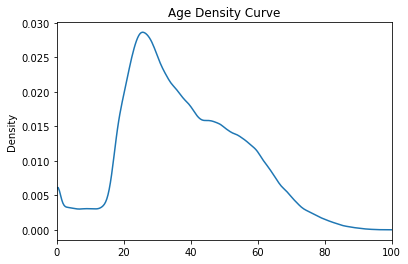

In [55]:
model_data["AGE"].plot(kind = 'density',xlim = (0,100),title = 'Age Density Curve')

In [56]:
injured_df["CRASH_HOUR"].value_counts()

16    33361
17    32523
15    32345
18    28586
14    28340
13    26106
12    22921
19    22663
11    20640
8     19609
20    18192
21    17632
10    17416
9     17149
22    16981
7     16511
23    13477
0     11359
6      9174
1      8530
2      7668
3      5661
5      5520
4      4953
Name: CRASH_HOUR, dtype: int64

In [57]:
injured_df['WEATHER_CONDITION'].value_counts()

CLEAR                     350984
RAIN                       46642
CLOUDY/OVERCAST            15092
SNOW                       14564
UNKNOWN                     5600
OTHER                       1768
FREEZING RAIN/DRIZZLE        852
FOG/SMOKE/HAZE               806
SLEET/HAIL                   749
BLOWING SNOW                 159
SEVERE CROSS WIND GATE       101
Name: WEATHER_CONDITION, dtype: int64

In [58]:
fata_sub['CRASH_MONTH'].value_counts()

5     845
7     462
6     452
11    368
10    357
3     343
8     334
9     287
4     276
1     274
12    252
2     146
Name: CRASH_MONTH, dtype: int64

In [59]:
fata_sub['CRASH_HOUR'].value_counts()

0     560
23    392
21    320
22    221
1     219
16    213
13    196
12    196
20    195
19    189
2     187
10    173
3     162
18    162
4     146
17    142
15    123
11    117
9     113
7      92
14     89
5      81
8      78
6      30
Name: CRASH_HOUR, dtype: int64

In [60]:
fata_sub["WEATHER_CONDITION"].value_counts()

CLEAR              3813
RAIN                352
CLOUDY/OVERCAST      90
SNOW                 65
UNKNOWN              64
FOG/SMOKE/HAZE        8
OTHER                 4
Name: WEATHER_CONDITION, dtype: int64

In [61]:
fata_sub["SAFETY_EQUIPMENT"].value_counts()

USAGE UNKNOWN                                 2098
SAFETY BELT USED                              1258
NONE PRESENT                                   427
NONE                                           244
SAFETY BELT NOT USED                           196
HELMET NOT USED                                 64
DOT COMPLIANT MOTORCYCLE HELMET                 42
HELMET USED                                     16
CHILD RESTRAINT USED                            10
CHILD RESTRAINT - REAR FACING                    9
CHILD RESTRAINT - FORWARD FACING                 8
WHEELCHAIR                                       8
CHILD RESTRAINT NOT USED                         8
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)       4
CHILD RESTRAINT - TYPE UNKNOWN                   2
NOT DOT COMPLIANT MOTORCYCLE HELMET              2
Name: SAFETY_EQUIPMENT, dtype: int64

In [62]:
non_injured_df

,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,CRASH_TYPE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,...,SEX,AGE,EJECTION,AIRBAG_DEPLOYED,DRIVER_ACTION,PEDPEDAL_ACTION,PHYSICAL_CONDITION,BAC_RESULT VALUE,SAFETY_EQUIPMENT,FATAL
0,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,IMPROPER BACKING,UNABLE TO DETERMINE,...,M,31.0,NONE,NOT APPLICABLE,IMPROPER BACKING,UNKNOWN/NA,NORMAL,0.0,USAGE UNKNOWN,0.0
1,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,IMPROPER BACKING,UNABLE TO DETERMINE,...,M,43.0,NONE,NOT APPLICABLE,NONE,UNKNOWN/NA,NORMAL,0.0,USAGE UNKNOWN,0.0
2,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,IMPROPER BACKING,UNABLE TO DETERMINE,...,M,28.0,NONE,NOT APPLICABLE,NaN,UNKNOWN/NA,UNKNOWN,0.0,USAGE UNKNOWN,0.0
3,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,IMPROPER BACKING,UNABLE TO DETERMINE,...,M,31.0,NONE,NOT APPLICABLE,IMPROPER BACKING,UNKNOWN/NA,NORMAL,0.0,USAGE UNKNOWN,0.0
4,35,CLEAR,DAYLIGHT,TURNING,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,IMPROPER BACKING,UNABLE TO DETERMINE,...,M,43.0,NONE,NOT APPLICABLE,NONE,UNKNOWN/NA,NORMAL,0.0,USAGE UNKNOWN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412771,15,CLEAR,DAYLIGHT,ANGLE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,UNABLE TO DETERMINE,UNABLE TO DETERMINE,...,M,73.0,NONE,NOT APPLICABLE,NONE,UNKNOWN/NA,NORMAL,0.0,SAFETY BELT USED,0.0
2412772,15,CLEAR,DAYLIGHT,ANGLE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,UNABLE TO DETERMINE,UNABLE TO DETERMINE,...,F,NaN,NONE,DID NOT DEPLOY,NaN,UNKNOWN/NA,UNKNOWN,0.0,SAFETY BELT USED,0.0
2412773,15,CLEAR,DAYLIGHT,ANGLE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,UNABLE TO DETERMINE,UNABLE TO DETERMINE,...,F,NaN,NONE,DID NOT DEPLOY,NaN,UNKNOWN/NA,UNKNOWN,0.0,SAFETY BELT USED,0.0
2412774,15,CLEAR,DAYLIGHT,ANGLE,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,UNABLE TO DETERMINE,UNABLE TO DETERMINE,...,F,37.0,NONE,DEPLOYMENT UNKNOWN,FAILED TO YIELD,UNKNOWN/NA,UNKNOWN,0.0,USAGE UNKNOWN,0.0


In [63]:
test.drop_duplicates(inplace = True)

In [64]:
test.columns

Index(['POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'CRASH_TYPE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE',
       'STREET_DIRECTION', 'BEAT_OF_OCCURRENCE', 'WORK_ZONE_I',
       'INJURIES_TOTAL', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'CRASH_UNIT_ID', 'MAKE', 'MODEL',
       'VEHICLE_TYPE', 'VEHICLE_DEFECT', 'TRAVEL_DIRECTION', 'MANEUVER',
       'FIRST_CONTACT_POINT', 'FIRE_I', 'PERSON_TYPE', 'SEX', 'AGE',
       'EJECTION', 'AIRBAG_DEPLOYED', 'DRIVER_ACTION', 'PEDPEDAL_ACTION',
       'PHYSICAL_CONDITION', 'BAC_RESULT VALUE', 'SAFETY_EQUIPMENT', 'FATAL',
       'BEAT_NUM', 'DISTRICT', 'CRASH_TOD', 'QUARTER'],
      dtype='object')

In [65]:
test.isnull().sum()

POSTED_SPEED_LIMIT               0
WEATHER_CONDITION                0
LIGHTING_CONDITION               0
FIRST_CRASH_TYPE                 0
ALIGNMENT                        0
ROADWAY_SURFACE_COND             0
ROAD_DEFECT                      0
CRASH_TYPE                       0
PRIM_CONTRIBUTORY_CAUSE          0
SEC_CONTRIBUTORY_CAUSE           0
STREET_DIRECTION                 6
BEAT_OF_OCCURRENCE               0
WORK_ZONE_I                      0
INJURIES_TOTAL                   0
CRASH_HOUR                       0
CRASH_DAY_OF_WEEK                0
CRASH_MONTH                      0
TRAFFICWAY_TYPE                  0
LANE_CNT                   1431180
CRASH_UNIT_ID                    0
MAKE                             0
MODEL                            0
VEHICLE_TYPE                     0
VEHICLE_DEFECT                   0
TRAVEL_DIRECTION                 0
MANEUVER                         0
FIRST_CONTACT_POINT              0
FIRE_I                           0
PERSON_TYPE         

In [66]:
fata_group = model_data.groupby('FATAL')

In [67]:

testing_samp = test.sample(80000)

inj_samp=test[test["INJURIES_TOTAL"]>0].sample(n=40000)
ok_samp=test[test["INJURIES_TOTAL"]==0].sample(n=40000)


fifty_fifty = pd.concat([inj_samp,ok_samp])
fifty_fifty = fifty_fifty.sample(n=80000)
# fifty_fifty = test


In [68]:
testing_samp.columns

Index(['POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'CRASH_TYPE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE',
       'STREET_DIRECTION', 'BEAT_OF_OCCURRENCE', 'WORK_ZONE_I',
       'INJURIES_TOTAL', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'CRASH_UNIT_ID', 'MAKE', 'MODEL',
       'VEHICLE_TYPE', 'VEHICLE_DEFECT', 'TRAVEL_DIRECTION', 'MANEUVER',
       'FIRST_CONTACT_POINT', 'FIRE_I', 'PERSON_TYPE', 'SEX', 'AGE',
       'EJECTION', 'AIRBAG_DEPLOYED', 'DRIVER_ACTION', 'PEDPEDAL_ACTION',
       'PHYSICAL_CONDITION', 'BAC_RESULT VALUE', 'SAFETY_EQUIPMENT', 'FATAL',
       'BEAT_NUM', 'DISTRICT', 'CRASH_TOD', 'QUARTER'],
      dtype='object')

In [69]:
fifty_fifty.columns

Index(['POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
       'CRASH_TYPE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE',
       'STREET_DIRECTION', 'BEAT_OF_OCCURRENCE', 'WORK_ZONE_I',
       'INJURIES_TOTAL', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'CRASH_UNIT_ID', 'MAKE', 'MODEL',
       'VEHICLE_TYPE', 'VEHICLE_DEFECT', 'TRAVEL_DIRECTION', 'MANEUVER',
       'FIRST_CONTACT_POINT', 'FIRE_I', 'PERSON_TYPE', 'SEX', 'AGE',
       'EJECTION', 'AIRBAG_DEPLOYED', 'DRIVER_ACTION', 'PEDPEDAL_ACTION',
       'PHYSICAL_CONDITION', 'BAC_RESULT VALUE', 'SAFETY_EQUIPMENT', 'FATAL',
       'BEAT_NUM', 'DISTRICT', 'CRASH_TOD', 'QUARTER'],
      dtype='object')

In [70]:
testing_samp = testing_samp[['PERSON_TYPE', 'SEX', 'EJECTION', 'AIRBAG_DEPLOYED',
       'DRIVER_ACTION', 'PEDPEDAL_ACTION', 'PHYSICAL_CONDITION',
       'BAC_RESULT VALUE', 'SAFETY_EQUIPMENT', 'MAKE'
       , 'VEHICLE_TYPE', 'VEHICLE_DEFECT', 'TRAVEL_DIRECTION',
       'MANEUVER', 'FIRST_CONTACT_POINT', 'FIRE_I', 
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
        'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE', 
       'PRIM_CONTRIBUTORY_CAUSE',  
        'WORK_ZONE_I', 'INJURIES_TOTAL',
       'CRASH_DAY_OF_WEEK', 'TRAFFICWAY_TYPE',
        'DISTRICT', 'CRASH_TOD', 'QUARTER']]

In [71]:
testing_samp = pd.get_dummies(testing_samp, columns = ['PERSON_TYPE', 'SEX', 'EJECTION', 'AIRBAG_DEPLOYED',
       'DRIVER_ACTION', 'PEDPEDAL_ACTION', 'PHYSICAL_CONDITION',
       'BAC_RESULT VALUE', 'SAFETY_EQUIPMENT', 'MAKE'
       , 'VEHICLE_TYPE', 'VEHICLE_DEFECT', 'TRAVEL_DIRECTION',
       'MANEUVER', 'FIRST_CONTACT_POINT', 'FIRE_I', 
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
        'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE', 
       'PRIM_CONTRIBUTORY_CAUSE', 
        'WORK_ZONE_I',
       'CRASH_DAY_OF_WEEK', 'TRAFFICWAY_TYPE',
        'DISTRICT', 'CRASH_TOD', 'QUARTER'],drop_first = True)
testing_samp

,INJURIES_TOTAL,PERSON_TYPE_DRIVER,PERSON_TYPE_NON-CONTACT VEHICLE,PERSON_TYPE_NON-MOTOR VEHICLE,PERSON_TYPE_PASSENGER,PERSON_TYPE_PEDESTRIAN,SEX_M,SEX_UNKNOWN,SEX_X,EJECTION_PARTIALLY EJECTED,...,DISTRICT_20,DISTRICT_22,DISTRICT_24,DISTRICT_25,CRASH_TOD_Evening,CRASH_TOD_Morning,CRASH_TOD_Night,QUARTER_Q2,QUARTER_Q3,QUARTER_Q4
1378726,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
644400,0.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
155577,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2353606,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1302784,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250123,0.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
930365,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
95751,0.0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1789682,0.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [72]:
fifty_feed =fifty_fifty[['PERSON_TYPE', 'SEX', 'EJECTION', 'AIRBAG_DEPLOYED',
       'DRIVER_ACTION', 'PEDPEDAL_ACTION', 'PHYSICAL_CONDITION',
       'BAC_RESULT VALUE', 'SAFETY_EQUIPMENT', 'MAKE'
       , 'VEHICLE_TYPE', 'VEHICLE_DEFECT', 'TRAVEL_DIRECTION',
       'MANEUVER', 'FIRST_CONTACT_POINT', 'FIRE_I', 
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
        'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE', 
       'PRIM_CONTRIBUTORY_CAUSE',  
        'WORK_ZONE_I', 'INJURIES_TOTAL',
       'CRASH_DAY_OF_WEEK', 'TRAFFICWAY_TYPE',
        'DISTRICT', 'CRASH_TOD', 'QUARTER']]

# fifty = fifty_feed.sample(n = 100000)

In [73]:
fifty_feed.shape

(80000, 30)

In [74]:
fifty_model = pd.get_dummies(fifty_feed, columns = ['PERSON_TYPE', 'SEX', 'EJECTION', 'AIRBAG_DEPLOYED',
       'DRIVER_ACTION', 'PEDPEDAL_ACTION', 'PHYSICAL_CONDITION',
       'BAC_RESULT VALUE', 'SAFETY_EQUIPMENT', 'MAKE'
       , 'VEHICLE_TYPE', 'VEHICLE_DEFECT', 'TRAVEL_DIRECTION',
       'MANEUVER', 'FIRST_CONTACT_POINT', 'FIRE_I', 
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
        'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE', 
       'PRIM_CONTRIBUTORY_CAUSE', 
        'WORK_ZONE_I',
       'CRASH_DAY_OF_WEEK', 'TRAFFICWAY_TYPE',
        'DISTRICT', 'CRASH_TOD', 'QUARTER'],drop_first = True)
fifty_model

,INJURIES_TOTAL,PERSON_TYPE_DRIVER,PERSON_TYPE_NON-CONTACT VEHICLE,PERSON_TYPE_NON-MOTOR VEHICLE,PERSON_TYPE_PASSENGER,PERSON_TYPE_PEDESTRIAN,SEX_M,SEX_UNKNOWN,SEX_X,EJECTION_PARTIALLY EJECTED,...,DISTRICT_20,DISTRICT_22,DISTRICT_24,DISTRICT_25,CRASH_TOD_Evening,CRASH_TOD_Morning,CRASH_TOD_Night,QUARTER_Q2,QUARTER_Q3,QUARTER_Q4
2196844,1.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
643897,1.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1388092,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1499917,1.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2295510,1.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619016,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
673544,0.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
430307,0.0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2353269,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [75]:
for col in testing_samp.columns:
    if col not in fifty_model.columns and col in testing_samp.columns:
        testing_samp.drop(col, inplace = True, axis = 1 )
for col in fifty_model.columns:
    if col not in testing_samp.columns and col in fifty_model.columns:
        fifty_model.drop(col, inplace = True, axis = 1 )        

In [76]:
fifty_model.shape,testing_samp.shape

((80000, 532), (80000, 532))

In [99]:
y = fifty_model['INJURIES_TOTAL']
X = fifty_model.drop(columns = ['INJURIES_TOTAL'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0,stratify = y)
model = LogisticRegression(n_jobs= -1, class_weight= 'balanced')
model.fit(X_train,y_train)

samp_pred = model.predict(X_test)
samp_score = model.score(X_test,y_test)

In [78]:
y_test1 = testing_samp["INJURIES_TOTAL"]
X_test1 = testing_samp.drop(columns = ['INJURIES_TOTAL'])
samp_pred1 = model.predict(X_test1)
samp_score1 = model.score(X_test1,y_test1)

In [79]:
samp_score, samp_score1

(0.93075, 0.883625)

In [80]:
metrics.confusion_matrix(y_test1,samp_pred1) #Unbalanced

array([[56382,  9221],
       [   89, 14308]])

In [81]:
metrics.confusion_matrix(y_test,samp_pred)#Balanced

array([[3459,  541],
       [  13, 3987]])

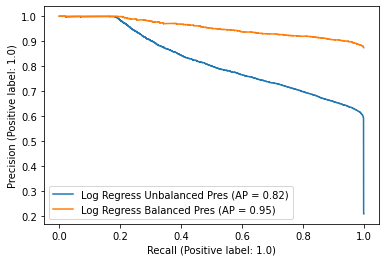

In [82]:
ax = plt.gca()
unbalanced_recall = plot_precision_recall_curve(model, X_test1, y_test1, ax = ax, name ='Log Regress Unbalanced Pres' )
unbalanced_recall = plot_precision_recall_curve(model, X_test, y_test,ax = ax, name = 'Log Regress Balanced Pres' )

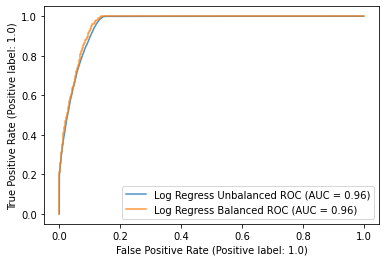

In [83]:
#unbalanced 
ax = plt.gca()
unbalanced_roc = plot_roc_curve(model, X_test1, y_test1, ax=ax, alpha=0.8,name= 'Log Regress Unbalanced ROC')
balanced_roc = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8, name = "Log Regress Balanced ROC")

plt.show()

In [103]:
y = fifty_model['INJURIES_TOTAL']
X = fifty_model.drop(columns = ['INJURIES_TOTAL'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .2 , random_state = 0,stratify = y)
rfc = RandomForestClassifier(n_estimators = 20,random_state = 0, class_weight = 'balanced')
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

In [85]:
y_test1 = testing_samp["INJURIES_TOTAL"]
X_test1 = testing_samp.drop(columns = ['INJURIES_TOTAL'])
samp_pred1 = rfc.predict(X_test1)
samp_score1 = rfc.score(X_test1,y_test1)

In [105]:


model = xgb.XGBClassifier().fit(X,y)

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

 99%|===================| 78922/80000 [01:12<00:00]        

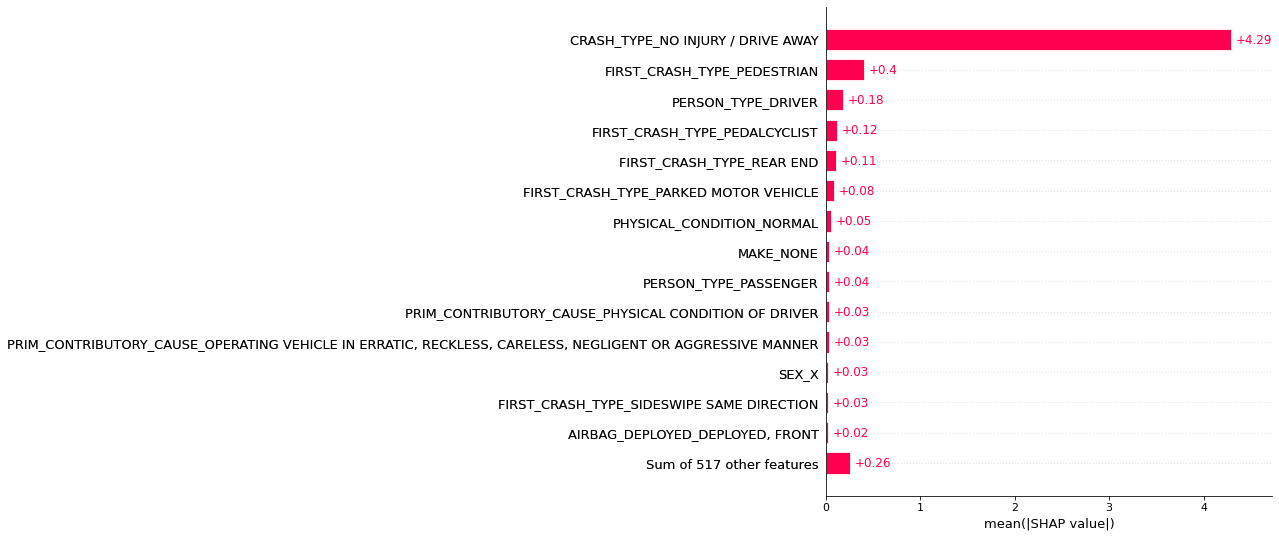

In [106]:
fig, ax= plt.subplots()
shap.plots.bar(shap_values,max_display= 15)
plt.style.use('dark_background')

In [86]:
metrics.confusion_matrix(y_test,y_pred) # Balanced

array([[6992, 1008],
       [ 198, 7802]])

In [87]:
metrics.confusion_matrix(y_test1,samp_pred1) #Unbalanced

array([[57073,  8530],
       [  292, 14105]])

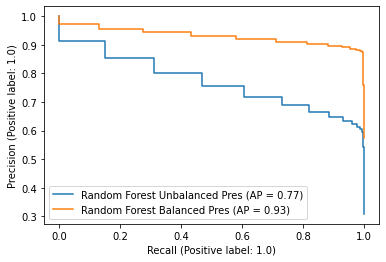

In [88]:
fig, ax = plt.subplots()

unbalanced_pres = plot_precision_recall_curve(rfc, X_test1, y_test1,ax = plt.gca(),name = 'Random Forest Unbalanced Pres')#Unbalanced
balanced_pres = plot_precision_recall_curve(rfc, X_test, y_test,ax = plt.gca(), name = 'Random Forest Balanced Pres')

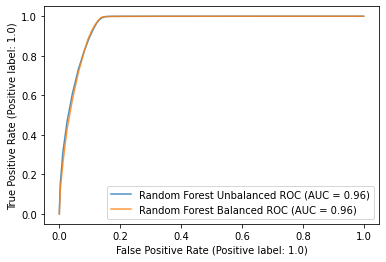

In [89]:
fig, ax = plt.subplots()
rfc_disp = plot_roc_curve(rfc, X_test1, y_test1, ax=plt.gca(), alpha=0.8, name = 'Random Forest Unbalanced ROC')
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=plt.gca(), alpha=0.8, name = 'Random Forest Balanced ROC')
plt.show()  #Balanced

/Users/winsometang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


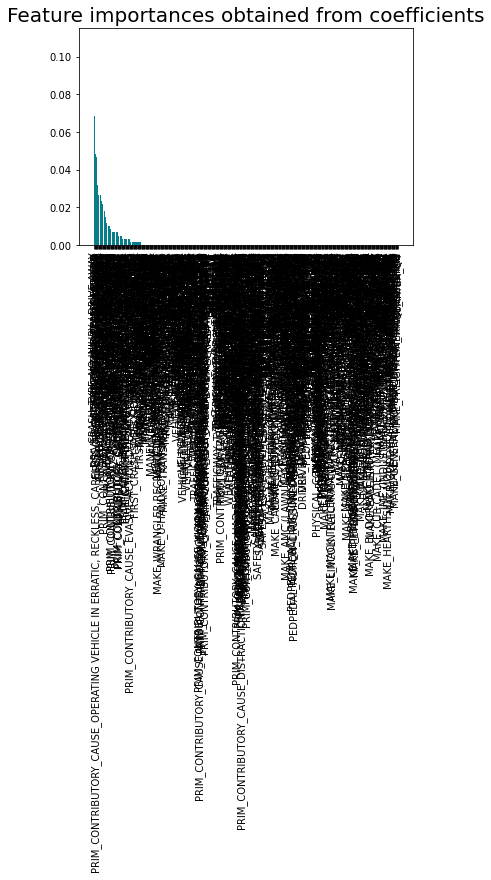

In [92]:
model = XGBClassifier()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)


plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

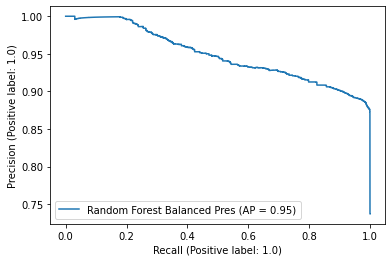

In [98]:
# unbalanced_pres = plot_precision_recall_curve(rfc, X_test1, y_test1,ax = plt.gca(),name = 'Random Forest Unbalanced Pres')#Unbalanced
balanced_pres = plot_precision_recall_curve(model, X_test, y_test,ax = plt.gca(), name = 'Random Forest Balanced Pres')

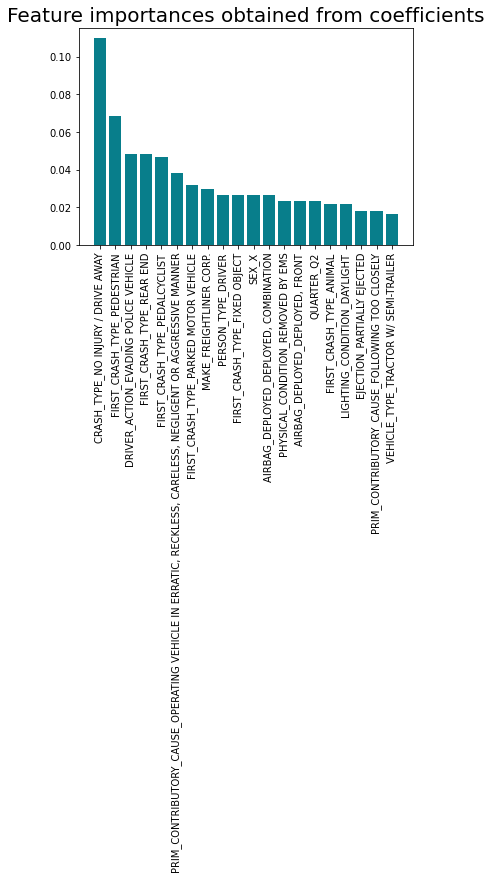

In [97]:
importances = importances[:20]
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()